# Contrastive Learning - Siamese Network

- We first define a CNN model that extracts features from images. 
- Then, we create two identical "Siamese" CNNs (shared weights) to process each image in a pair. 
- The contrastive loss function is defined to encourage similar images to have similar embeddings and dissimilar images to have - dissimilar embeddings. 
- Finally, the Siamese model is compiled and trained using pairs of images and their corresponding labels indicating whether they are - similar or dissimilar.

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Lambda
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.utils import plot_model
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

In [2]:
# Sample image data (for demonstration)
# Assuming image data is already preprocessed and loaded into numpy arrays
images = np.random.randn(100, 64, 64, 3)  # 100 images of size 64x64 with 3 channels

## Siamese Network

In [3]:
input_shape = (64, 64, 3)
embedding_dim = 64

# Shared CNN model
def create_base_network(input_shape):
    model_input = Input(shape=input_shape)
    x = Conv2D(32, (3, 3), activation='relu')(model_input)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(128, (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Flatten()(x)
    x = Dense(embedding_dim)(x)
    return Model(model_input, x)

# Create the base network
base_network = create_base_network(input_shape)

# Define Siamese network architecture
input_image1 = Input(shape=input_shape)
input_image2 = Input(shape=input_shape)

# Encoded representations of the input images
encoded_image1 = base_network(input_image1)
encoded_image2 = base_network(input_image2)

## Contrastive loss 

In [4]:
# Contrastive loss function
def contrastive_loss(y_true, y_pred):
    margin = 1
    y_true = K.cast(y_true, dtype=K.floatx())  # Cast labels to the same data type as predictions
    return K.mean(y_true * K.square(y_pred) + (1 - y_true) * K.square(K.maximum(margin - y_pred, 0)))

# Calculate Euclidean distance between embedded vectors
def euclidean_distance(vects):
    x, y = vects
    return K.sqrt(K.sum(K.square(x - y), axis=1, keepdims=True))

# Define contrastive distance layer
distance = Lambda(euclidean_distance)([encoded_image1, encoded_image2])

# Create Siamese model
siamese_model = Model(inputs=[input_image1, input_image2], outputs=distance)

# Compile the model
siamese_model.compile(loss=contrastive_loss, optimizer='adam')

In [5]:
siamese_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 input_3 (InputLayer)        [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 model (Functional)          (None, 64)                   388224    ['input_2[0][0]',             
                                                                     'input_3[0][0]']             
                                                                                                  
 lambda (Lambda)             (None, 1)                    0         ['model[0][0]',         

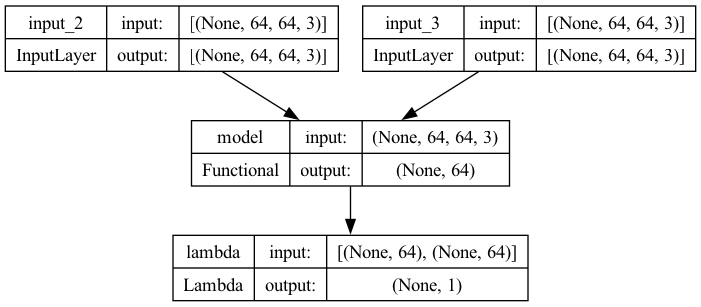

In [6]:
plot_model(siamese_model,show_shapes = True, show_layer_names = True)

In [7]:
#Generate pairs of similar and dissimilar images
def generate_pairs(images):
    pairs = []
    labels = []
    num_images = images.shape[0]
    for i in range(num_images):
        img1 = images[i]
        for j in range(i+1, num_images):
            img2 = images[j]
            pairs.append([img1, img2])
            labels.append(1) if i == j else labels.append(0)
    return np.array(pairs), np.array(labels)

In [8]:
# Train the model
pairs, labels = generate_pairs(images)
siamese_model.fit([pairs[:, 0], pairs[:, 1]], labels, epochs=3, batch_size=16)

Epoch 1/3
310/310 [==============================] - 6s 19ms/step - loss: 3.4111e-05
Epoch 2/3
310/310 [==============================] - 7s 21ms/step - loss: 0.0000e+00
Epoch 3/3
310/310 [==============================] - 7s 22ms/step - loss: 0.0000e+00


In [11]:
# Generate random pair of images
new_pair = np.random.randn(2, 64, 64, 3)  # Assuming new_pair contains a pair of images

# Get the first and second images from new_pair
image1 = new_pair[0]  # First image
image2 = new_pair[1]  # Second image
print(image1.shape)

# Reshape the images to have the correct shape and add a batch dimension
image1 = np.expand_dims(image1, axis=0)  # Add batch dimension
image2 = np.expand_dims(image2, axis=0)  # Add batch dimension

print(image1.shape)

(64, 64, 3)
(1, 64, 64, 3)


In [12]:
# Make prediction
prediction = siamese_model.predict([image1, image2])

# The prediction will be the contrastive distance between the two images
print("Contrastive Distance:", prediction)

1/1 [==============================] - 0s 38ms/step
Contrastive Distance: [[1.6245368]]


### Visualize Embeddings

4/4 [==============================] - 0s 7ms/step


/var/folders/dr/_x17x1d14k3614c36x1bhwbh0000gn/T/ipykernel_40716/3479763325.py:10: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(embedded_images_tsne[:, 0], embedded_images_tsne[:, 1], marker='o', cmap='viridis')


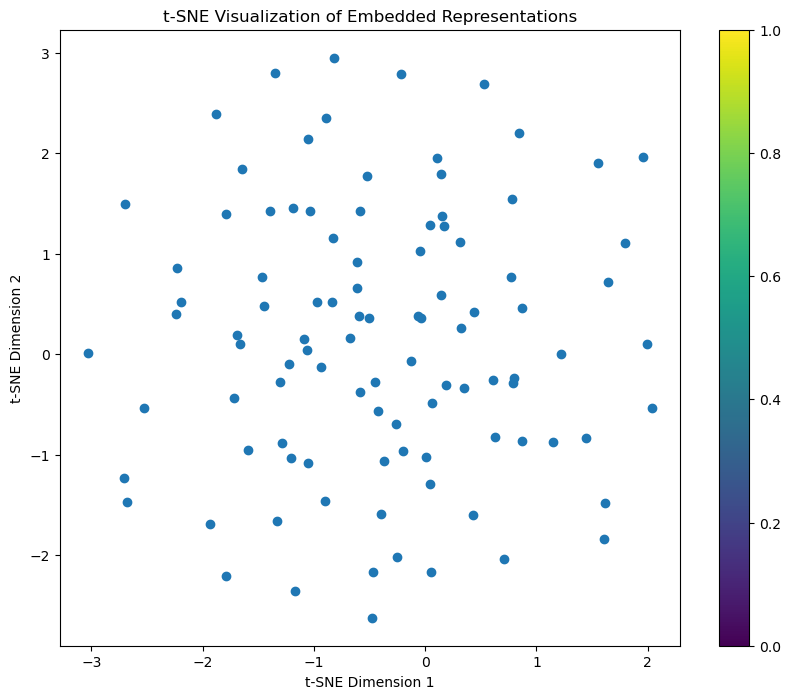

In [13]:
# Get the embedded representations from the base network
embedded_images = base_network.predict(images)

# Reduce dimensionality with t-SNE
tsne = TSNE(n_components=2, random_state=42)
embedded_images_tsne = tsne.fit_transform(embedded_images)

# Plot the embedded representations
plt.figure(figsize=(10, 8))
plt.scatter(embedded_images_tsne[:, 0], embedded_images_tsne[:, 1], marker='o', cmap='viridis')
plt.title('t-SNE Visualization of Embedded Representations')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.colorbar()
plt.show()